# QP2 Analyses
## 6 Dec 2025





In [1]:
## Cleaning the Data (R)


# Loading packages
library(tidyverse)

# Loading Files

files <- list.files(path = "D:/BNC Full Data/12-6_1PM Run/CSV",
                    pattern = "\\.csv$",
                    full.names = TRUE)

df <- read_csv(files, id = "file_name")
write_rds(df, "D:/BNC Full Data/12-6_1PM Run/full_results-12-6.rds")

# df <- read_csv("full_csv.csv")

# Filtering

df <- df %>% 
    arrange(Sentence_ID) %>% # Removes duplicates
        group_by(Sentence_Text) %>%
        mutate(first_Sentence_ID = first(Sentence_ID)) %>%
        filter(Sentence_ID == first_Sentence_ID) %>%
        ungroup() %>%
        select(-first_Sentence_ID) %>% 
    filter(Is_NP == TRUE, # Filtering Criteria
            Is_Head_Noun == TRUE,
            Modality == "written", 
            Sent_Verb_Count == 1,
            Sent_Auxiliary_Count == 0,
            Sent_Subject_Count == 1,
            Sent_Tot_Obj_Count %in% 1,
            Sent_Dir_Object_Count == 1 ,
            Sent_Ind_Object_Count == 0,
            Sent_Sub_Conj_Count == 0,
            Sent_Coord_Conj_Count == 0, 
            Clausal_Complement_Count == 0,
            Sent_Relative_Clause_Count == 0, 
            Sent_Adv_Clause_Count == 0, 
            Sent_Prep_Phrase_Count == 0,
            Sent_Comma_Count == 0,
            !str_detect(Sentence_Text, "\\?"),
            NP_Definiteness  %in% c("definite", "indefinite"),
            NP_Argument %in% c("subject", "dir_object"),
            Sent_Transitive == TRUE,
            ) %>%
            drop_na(Phrase_Surprisal) %>% # Drops values w/out valid surprisal value
            group_by(Sentence_ID) %>% # Drops sentences without one subject and one object
                filter(n() == 2 & n_distinct(NP_Argument) == 2) %>%
                ungroup()

# Cleaning up DF leaving only what's needed for analysis

df <- df %>% 
    mutate(
        definiteness = factor(NP_Definiteness,
        levels = c("indefinite", "definite"),
        labels = c("indef", "def"))
    ) %>% 
    mutate(
        argPos = factor(
            NP_Argument,
            levels = c("dir_object", "subject"),
            labels = c("obj", "sbj")
        )
    ) %>% 
    mutate(surprisal = Phrase_Surprisal) %>% 
    select(Sentence_ID, Sentence_Text, Phrase_Token, surprisal, definiteness, argPos)

saveRDS(df, file = "Results 11-22/filtered_df_1122.rds")
write_csv(df, "Results 11-22/filtered_csv_1122.csv")





── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 31135659 Columns: 44
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): Sentence_ID, Filename, Modality, Sentence_Text, Word_Token, Phrase...
dbl (18): Sent_Verb_Count, Sent_Auxiliary_Count, Sent_Subject_Count, Sent_To...
lgl  (4): Sent_Transitive, Is_NP, NP_Is_Bare_NP, Is_Head_Noun

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE`

# Statistical Analysis

## Preparation

In [2]:
library(tidyverse)
library(easystats)
library(ggplot2)
# library(ggeffects)
    plotFont <- function(fontBase) { # Easy way to adjust font size for plots
        theme( # Add as a final ggplot object (no parentheses)
        plot.title = element_text(size = 14*fontBase),      # Title font size
        axis.title.x = element_text(size = 12*fontBase),    # X-axis title font size
        axis.title.y = element_text(size = 12*fontBase),    # Y-axis title font size
        axis.text.x = element_text(size = 10*fontBase),     # X-axis tick labels font size
        axis.text.y = element_text(size = 10*fontBase),     # Y-axis tick labels font size
        legend.text = element_text(size = 10*fontBase),     # Legend text size
        legend.title = element_text(size = 10*fontBase),    # Legend title size
        strip.text = element_text(size = 10*fontBase)
        )
    }

# df <- read_csv("words_filtered_clean_FINAL.csv",
#                 col_types = cols(
#                 definiteness = col_factor(levels = c("indef", "def")),
#                 argPos = col_factor(levels = c("obj", "sbj"))))

# df <- readRDS("Filtered Results 11-21/filtered_df-11-21.rds")

head(df)
levels(df$definiteness)
levels(df$argPos)

# Attaching packages: easystats 0.7.5 (red = needs update)
✔ bayestestR  0.17.0   ✔ correlation 0.8.8 
✖ datawizard  1.2.0    ✔ effectsize  1.0.1 
✖ insight     1.4.2    ✔ modelbased  0.13.0
✖ performance 0.15.1   ✖ parameters  0.28.1
✖ report      0.6.1    ✖ see         0.11.0

Restart the R-Session and update packages with `easystats::easystats_update()`.




Sentence_ID,Sentence_Text,Phrase_Token,surprisal,definiteness,argPos
<chr>,<chr>,<chr>,<dbl>,<fct>,<fct>
A01_110,All our programmes need your continued support .,All our programmes,15.91927,def,sbj
A01_110,All our programmes need your continued support .,your continued support,13.60938,def,obj
A01_61,Friendship takes time .,Friendship,15.44531,indef,sbj
A01_61,Friendship takes time .,time,16.20312,indef,obj
A02_12,Governmental organisations support us financially .,Governmental organisations,14.15820,indef,sbj
A02_12,Governmental organisations support us financially .,us,15.37500,def,obj


[1] "indef" "def"

[1] "obj" "sbj"

In [3]:
summary(df)
prop_table_def <- df %>% 
    count(definiteness, argPos) %>% 
    group_by(definiteness) %>% 
    mutate(proportion = n / sum(n))

    prop_table_def

prop_table_arg <- df %>% 
    count(argPos, definiteness) %>% 
    group_by(argPos) %>% 
    mutate(proportion = n / sum(n))

    prop_table_arg

count_table <- df %>% 
    group_by(argPos, definiteness) %>% 
    count()

    count_table

 Sentence_ID        Sentence_Text      Phrase_Token         surprisal     
 Length:15872       Length:15872       Length:15872       Min.   : 1.817  
 Class :character   Class :character   Class :character   1st Qu.:13.781  
 Mode  :character   Mode  :character   Mode  :character   Median :16.188  
                                                          Mean   :16.556  
                                                          3rd Qu.:19.010  
                                                          Max.   :42.375  
 definiteness  argPos    
 indef: 4094   obj:7936  
 def  :11778   sbj:7936  
                         
                         
                         
                         

definiteness,argPos,n,proportion
<fct>,<fct>,<int>,<dbl>
indef,obj,3041,0.7427943
indef,sbj,1053,0.2572057
def,obj,4895,0.4156054
def,sbj,6883,0.5843946


argPos,definiteness,n,proportion
<fct>,<fct>,<int>,<dbl>
obj,indef,3041,0.3831905
obj,def,4895,0.6168095
sbj,indef,1053,0.1326865
sbj,def,6883,0.8673135


argPos,definiteness,n
<fct>,<fct>,<int>
obj,indef,3041
obj,def,4895
sbj,indef,1053
sbj,def,6883


## Combined

### Model

In [4]:
model <- lm(data=df, surprisal ~ argPos * definiteness)
summary(model)


Call:
lm(formula = surprisal ~ argPos * definiteness, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-14.405  -2.444  -0.268   2.100  23.998 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)               14.96621    0.06890 217.218  < 2e-16 ***
argPossbj                  2.63829    0.13586  19.420  < 2e-16 ***
definitenessdef           -0.20882    0.08773  -2.380   0.0173 *  
argPossbj:definitenessdef  0.98171    0.15331   6.404 1.56e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.799 on 15868 degrees of freedom
Multiple R-squared:  0.1718,	Adjusted R-squared:  0.1716 
F-statistic:  1097 on 3 and 15868 DF,  p-value: < 2.2e-16


### Plot (Main Effects)

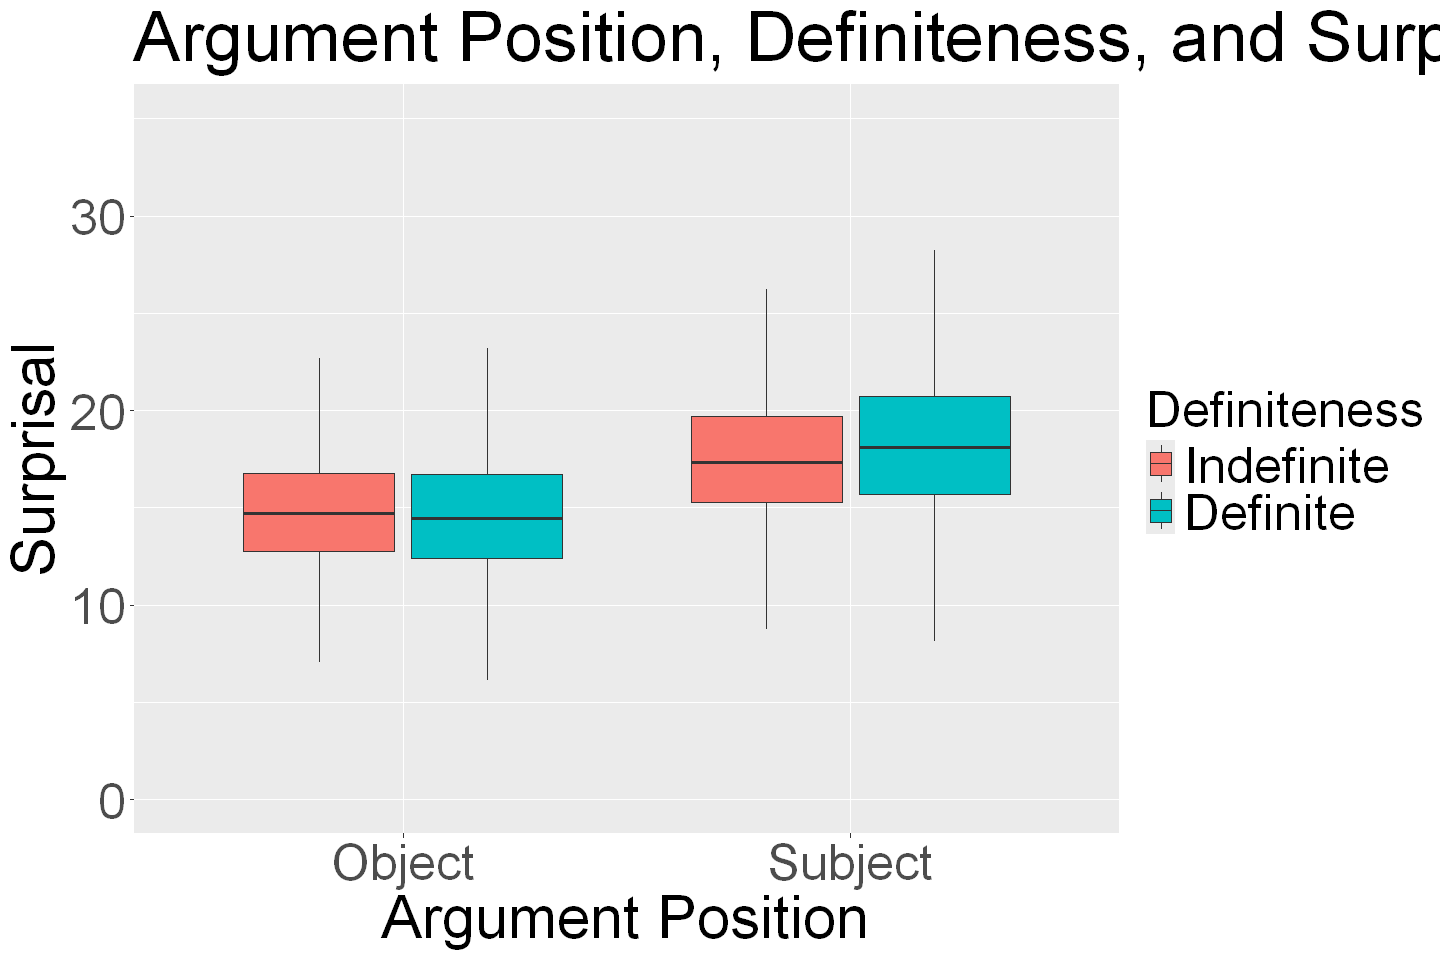

In [5]:
options(repr.plot.width = 12, repr.plot.height = 8)

plot <- ggplot(data = df, aes(x = argPos, y = surprisal, fill = definiteness)) +
    geom_boxplot(outlier.shape = NA) +
        coord_cartesian(ylim = c(0, 35)) +
    labs(
        title = "Argument Position, Definiteness, and Surprisal",
        x = "Argument Position",
        y = "Surprisal",
        fill = "Definiteness"
    ) + 
    scale_x_discrete(labels = c("sbj" = "Subject", "obj" = "Object")) +
    scale_fill_discrete(labels = c("def" = "Definite", "indef" = "Indefinite"))+
    plotFont(3) 


plot

ggsave("plot126.png",
        plot = plot,
        scale = 1.5,
        units = "in",
        height = 8, width = 12,
        dpi = 600)